In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from mhm_dataprocessing import *

#font segoe ui
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Segoe UI'

#### Read data

In [2]:
mhm_flux_data = xr.open_dataset(r"W:\VUB\_main_research\mHM\mhm_outputs\mHM_Fluxes_States.nc")

#shapefile mask
be_shp = gpd.read_file(r"W:\VUB\_main_research\mHM\mhm_belgium\be_shp\be.shp")


#### Read data and clip to BE

In [3]:
be_data = clip_to_region(be_shp, mhm_flux_data)

#resample to month ends
#resample fluxes to month ends
variables = ['SM_L01','SM_L02','SM_L03','SM_Lall','SWC_L01','SWC_L02','SWC_L03','recharge']

mhm_fluxes_mon= be_data[variables].resample(time='M').mean()

c:\Users\kart\anaconda3\envs\py_data_analysis\lib\site-packages\xarray\core\groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


#### SMI and drought characteristics

In [4]:
#compute anomalies
#extract summer period JJA
summer_months = [6,7,8]
#extract values for summer months
data_summer = mhm_fluxes_mon.sel(time=mhm_fluxes_mon.time.dt.month.isin(summer_months))

#average soil moisture for summer months for each year
data_summer_avg = data_summer.groupby('time.year').mean()


### compute anomalies

In [5]:
monthly_anomalies = compute_standardized_anomaly(mhm_fluxes_mon, 'M')

c:\Users\kart\anaconda3\envs\py_data_analysis\lib\site-packages\xarray\core\groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


In [7]:
#extract summer anomalies
summer_months = [6,7,8]

summer_anomalies = monthly_anomalies.sel(time=mhm_fluxes_mon.time.dt.month.isin(summer_months))

In [8]:
#aggregate yearly
summer_average_anomaly = summer_anomalies.groupby('time.year').mean()

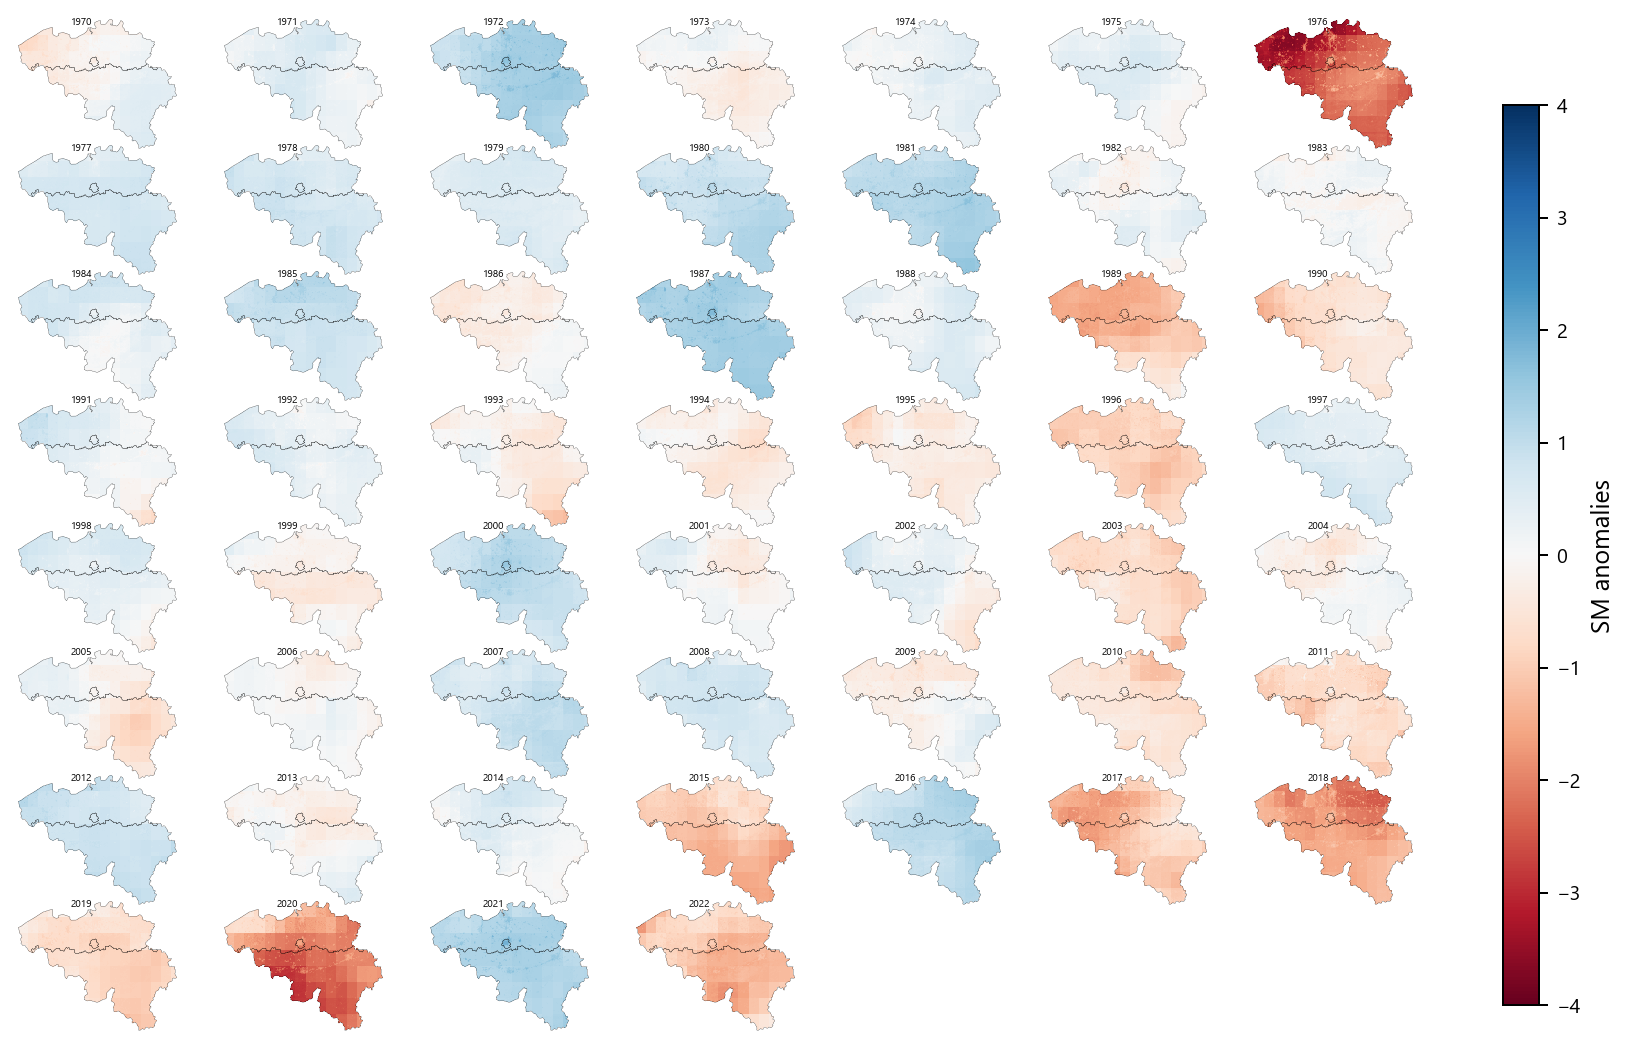

In [24]:
fig, ax = plt.subplots(10, 7,subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 10), dpi=180)
# Flatten the 2D array of axes
axes = ax.flatten()
plt.subplots_adjust(hspace=-0.5, wspace=0.3)
# Loop through each time slice and its corresponding subplot
for i, time in enumerate(summer_average_anomaly.year.values):
    if i < len(axes):  # Ensure we do not exceed the number of subplots
        im = summer_average_anomaly['SM_L02'].sel(year=time).plot(
            ax=axes[i], cmap='RdBu',
            robust=True,
            vmin=-4,
            vmax=4,
            add_colorbar=False
        )
        axes[i].set_title(str(time), fontsize=4, x=0.4, y=0.85)  # Add a small title to each plot
        be_shp.boundary.plot(ax=axes[i], edgecolor='black', linewidth=0.1)
        # Remove the frame
        axes[i].set_frame_on(False)
    else:
        break
# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
# Add a shared colorbar
cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.5])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='SM anomalies')
cbar_ax.tick_params(labelsize=8)
plt.show()

#### Stacked area anomalies

C:\Users\kart\AppData\Local\Temp\ipykernel_34324\3361353711.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
5      0.000000
6     58.467001
7      0.000000
8      0.000000
9      0.000000
10     0.000000
11     0.000000
12     0.000000
13     0.000000
14     0.000000
15     0.000000
16     0.000000
17     0.000000
18     0.000000
19     0.000000
20     0.000000
21     0.000000
22     0.000000
23     0.000000
24     0.000000
25     0.000000
26     0.000000
27     0.000000
28     0.000000
29     0.000000
30     0.000000
31     0.000000
32     0.000000
33     0.000000
34     0.000000
35     0.000000
36     0.000000
37     0.000000
38     0.000000
39     0.000000
40     0.000000
41     3.970343
42     0.000000
43     0.000000
44     0.000000
45     0.000000
46     0.000000
47     2.324561
48    17.802840
49     0.000000
50    22.236842

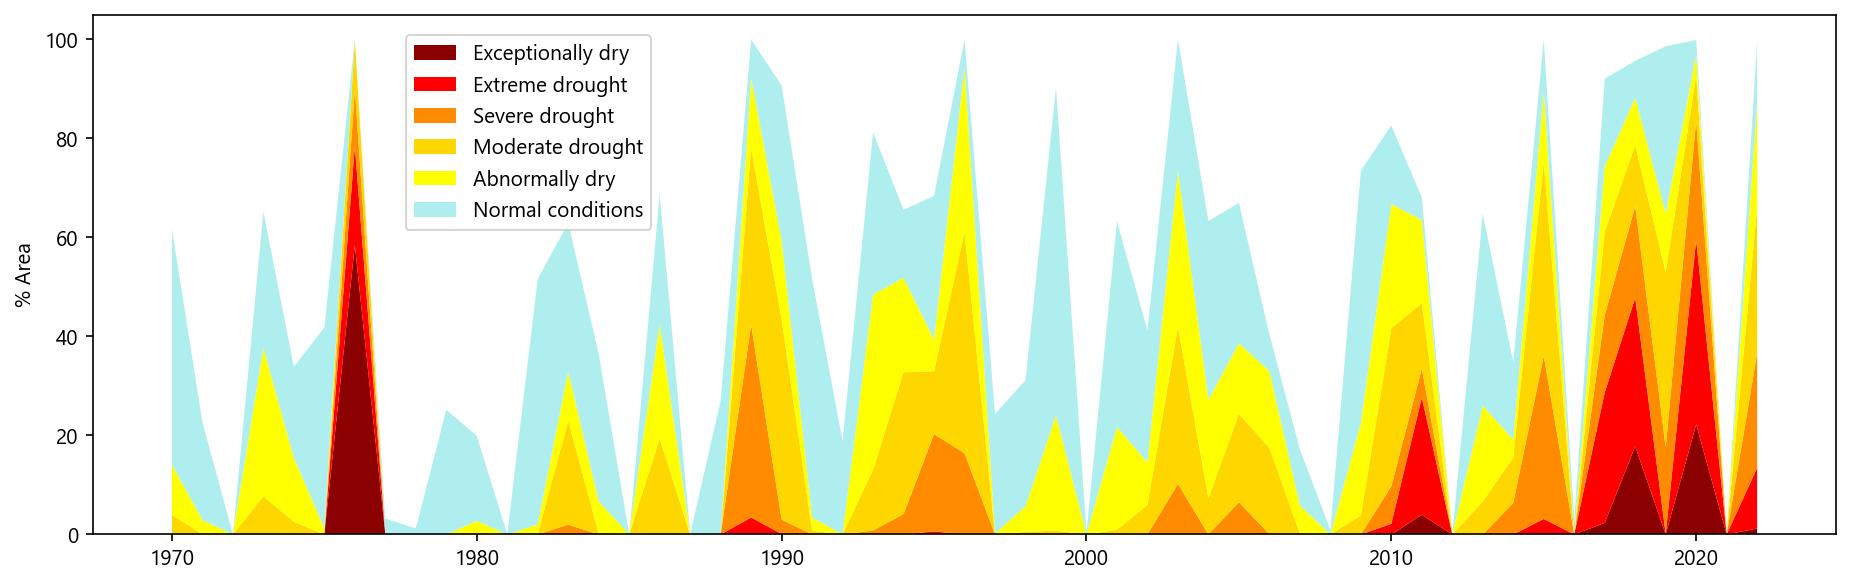

In [13]:
# Drop NaN values before calculating percentiles
valid_values = summer_anomalies['SM_L02'].values[~np.isnan(summer_anomalies['SM_L02'].values)]

# Define the percentiles
percentiles = [2,5,10,20,30,50,70,95]
percentile_labels = ['Exceptionally dry', 'Extreme drought', 'Severe drought', 'Moderate drought', 'Abnormally dry','Normal conditions','Wetter than normal', 'Very wet', 'Extremely wet']

# Calculate the percentile thresholds for the valid dataset
thresholds = np.percentile(valid_values, percentiles)

# Include bounds for categories
bounds = [-np.inf] + list(thresholds) + [np.inf]


# Group by year and classify data
results = []
for year, data in summer_anomalies.groupby('time.year'):
    # Classify data into percentile bins
    binned = xr.apply_ufunc(
        np.digitize,
        data['SM_L02'],
        input_core_dims=[[]],
        kwargs={'bins': bounds},
    )
    
    # Count the number of values in each bin
    counts = [(binned == i).sum().item() for i in range(1, len(bounds))]
    results.append([year] + counts)

# Convert results into a DataFrame
df = pd.DataFrame(results, columns=['Year'] + percentile_labels)

# Normalize (if needed)
# If you want relative percentages, divide by total grid cells
df.iloc[:, 1:] = df.iloc[:, 1:].div(df.iloc[:, 1:].sum(axis=1), axis=0) * 100

# Plot the stacked area chart
fig, ax = plt.subplots(figsize=(15, 4.5),dpi=150)
ax.stackplot(df.Year, df.iloc[:,[1,2,3,4,5,6]].T, labels=percentile_labels[0:6], colors = ['darkred','red','darkorange','gold','yellow','paleturquoise'])
ax.set_ylabel("% Area")
ax.legend(loc='upper center', bbox_to_anchor=(0.25, 0.98), ncols =1)
#plt.axvline(pd.to_datetime('1976'))
plt.show()

In [14]:
df

,Year,Exceptionally dry,Extreme drought,Severe drought,Moderate drought,Abnormally dry,Normal conditions,Wetter than normal,Very wet,Extremely wet
0,1970,0.000000,0.000000,0.091896,3.845029,10.148287,47.616959,26.294904,12.002924,0.000000
1,1971,0.000000,0.000000,0.000000,0.052214,2.865497,19.782790,49.482038,27.817460,0.000000
2,1972,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.221805,68.045113,30.733083
3,1973,0.000000,0.000000,0.000000,7.700501,29.968672,27.550125,24.607352,10.173350,0.000000
4,1974,0.000000,0.000000,0.000000,2.552214,12.911445,18.393901,27.406015,38.736424,0.000000
5,1975,0.000000,0.000000,0.000000,0.000000,1.225982,40.561821,31.904762,26.307435,0.000000
6,1976,58.467001,19.941520,11.572682,9.816207,0.202590,0.000000,0.000000,0.000000,0.000000
7,1977,0.000000,0.000000,0.000000,0.000000,0.004177,3.168338,40.685046,56.083960,0.058480
8,1978,0.000000,0.000000,0.000000,0.000000,0.000000,1.215539,35.050125,63.709273,0.025063
9,1979,0.000000,0.000000,0.000000,0.000000,0.000000,25.179616,38.558897,34.801587,1.459900
